In [249]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [250]:
# !/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --user seaborn

In [251]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [252]:
#Define get_cost function
def get_cost(context, action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    if context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [253]:
#Covert to vw format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [254]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [255]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [256]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [257]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [304]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = get_cost(context, action)
        cost_sum += cost
        
        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)
    print("Average CTR: ", -1*cost_sum/(num_iterations))
    return ctr

In [305]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# First Scenario

Average CTR:  0.7972


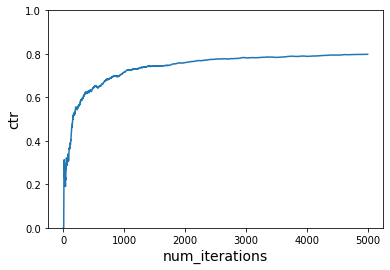

In [306]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

Average CTR:  0.142


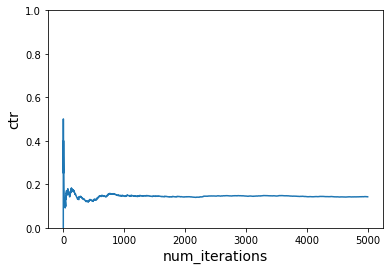

In [307]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

# Second Scenario

In [308]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [309]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    print("Average CTR: ", -1*cost_sum/(num_iterations*len(cost_functions)))
    return ctr

Average CTR:  0.8074


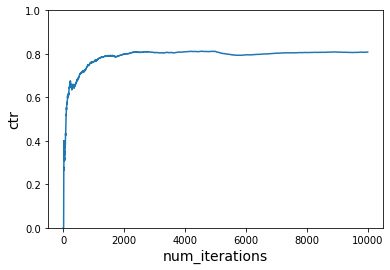

In [312]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Average CTR:  0.143


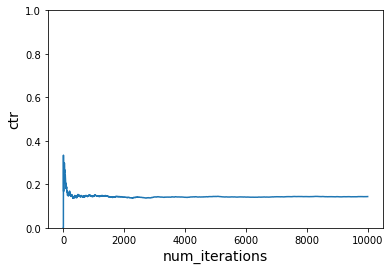

In [313]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

# 1. Rewards Incrementer

In [266]:
def run_simulation_with_rewards_incrementer(vw, num_iterations, users, times_of_day, actions, cost_functions, rewards_increment, do_learn = True):
    cost_sum = 0.
    ctr = []
    
    record_info = {"Tom":{"iterations":[], "action":[], "time_of_day":[]}, "Anna":{"iterations":[], "action":[], "time_of_day":[]}}
    
    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        current_increment_value = rewards_increment
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)
            
            #Lets record the context along with the action taken by the model for each iteration
            record_info[context['user']]['iterations'].append(i)
            record_info[context['user']]['action'].append(action)
            record_info[context['user']]['time_of_day'].append(context['time_of_day'])

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            # cost = -1 indicates a reward. With every successive reward, the reward value is incremented by the value specified in 'rewards_increment'
            if cost == -1:
                cost = cost+current_increment_value
                current_increment_value += rewards_increment
                cost_sum -= 1 
            # cost = 0 indicates no reward. If there was a successive run of rewards previously, a 'no rewards' action breaks the streak and sets the 'current_increment_value' back to the original 'rewards_increment' value
            elif cost == 0:
                current_increment_value = rewards_increment

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    print("Average CTR: ", -1*cost_sum/(num_iterations*len(cost_functions)))
    return ctr, record_info

Average CTR:  0.7921
Average CTR:  0.6313


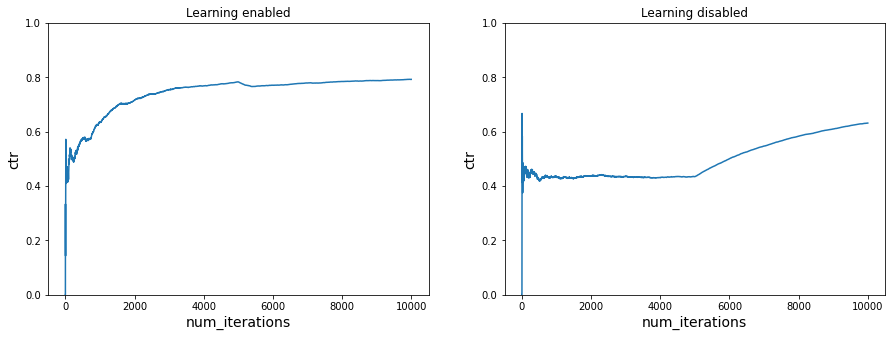

In [317]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
rewards_increment = -0.00005 #-1e-05=-0.00005
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)
#With learning 
ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)
#No learning
ctr_nl, record_info_nl = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment, do_learn = False)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Learning enabled")
plot_ctr(total_iterations, ctr)
plt.subplot(122)
plt.title("Learning disabled")
plot_ctr(total_iterations, ctr_nl)

In [268]:
#Map the time of day to a color for visualization
def color_time_of_day_map(tod):
    if tod == "morning":
        return 0
    elif tod == "afternoon":
        return 1

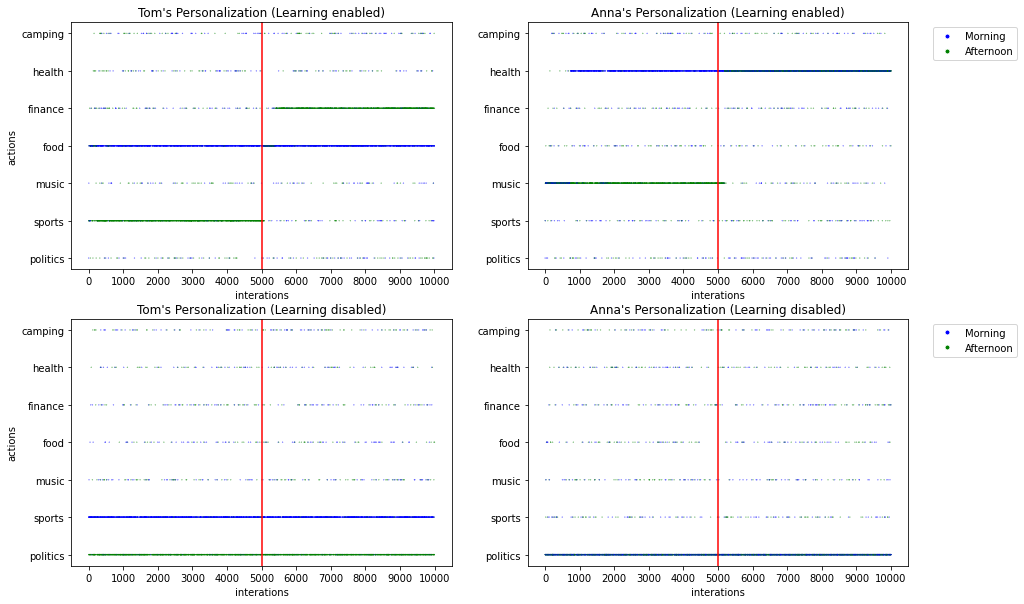

In [321]:
#Side-by-side comparision of Tom's and Anna's Personalization
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
colours = ListedColormap(['b','g'])
classes=["morning", "afternoon"]
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5)]

plt.subplot(221)
plt.title('Tom\'s Personalization (Learning enabled)')
plt.xlabel('interations')
plt.ylabel('actions')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.axvline(x=total_iterations/2, color='r')
plt.scatter(record_info['Tom']['iterations'], record_info['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info['Tom']['time_of_day']], cmap=colours, s=.05)

plt.subplot(222)
plt.title('Anna\'s Personalization (Learning enabled)')
plt.xlabel('interations')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.scatter(record_info['Anna']['iterations'], record_info['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info['Anna']['time_of_day']], cmap=colours, s=.05)
plt.axvline(x=total_iterations/2, color='r')
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.subplot(223)
plt.title('Tom\'s Personalization (Learning disabled)')
plt.xlabel('interations')
plt.ylabel('actions')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.axvline(x=total_iterations/2, color='r')
plt.scatter(record_info_nl['Tom']['iterations'], record_info_nl['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_nl['Tom']['time_of_day']], cmap=colours, s=.05)

plt.subplot(224)
plt.title('Anna\'s Personalization (Learning disabled)')
plt.xlabel('interations')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.scatter(record_info_nl['Anna']['iterations'], record_info_nl['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_nl['Anna']['time_of_day']], cmap=colours, s=.05)
plt.axvline(x=total_iterations/2, color='r')
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.show()


* The red line is a separation between the two cost functions
* There is an initial period of exploration in the beginning and right after the new cost function (red line). After which the algorithm quickly converges to its preferred choice of action
* There are actions suggested by the model on the other actions as well which suggest that the exploration process never really stops. 

# 2. Visualizing the exploration algorithms
##### Note: We'll be using the custom 'reward incrementor' as the default simulator to test and compare different models. For the sake of simplicity and ease of visualization, we shall only visualize Tom's personalization even though the model is learning and predicting both Anna and Tom's preferences. 

In [274]:
#Function to generate 2x1 subplots between the ctr value and chosen action over the iterations
def subplots_ctr_actions(ctr, record_info, actions, total_iterations):
    plt.figure(figsize=(10,10))
    colours = ListedColormap(['b','g'])
    classes=["morning", "afternoon"]
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5)]
    
    plt.subplot(211)
    plt.title('Tom\'s Personalization')
    plot_ctr(total_iterations, ctr)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(212)
    plt.xlabel('interations')
    plt.ylabel('actions')
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info['Tom']['iterations'], record_info['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info['Tom']['time_of_day']], cmap=colours, s=.05)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()

### 2 a. Epsilon-Greedy
* Given that Epsilon-Greedy is the default exploration algorithm, let's start with it. The epsilon-greedy method is a balance between exploration and exploitation. 
* A higher epsilon value indicates a higher tendency to explore. Which means the policy would most probably chose an action at random to improve the accuracy of the estimated action-values and hence improve decision making for the future.
* A lower epsilon value on the other hand would tend the policy towards exploitation aka the greedy method. It would choose an action that would most likely give it a reward. This might be detrimental in the long run when trying to find the optimal action-values.

#### 2. a. (i) Setting a low epsilon value such as 0.1, the policy will clearly favour exploitation

Average CTR:  0.8825


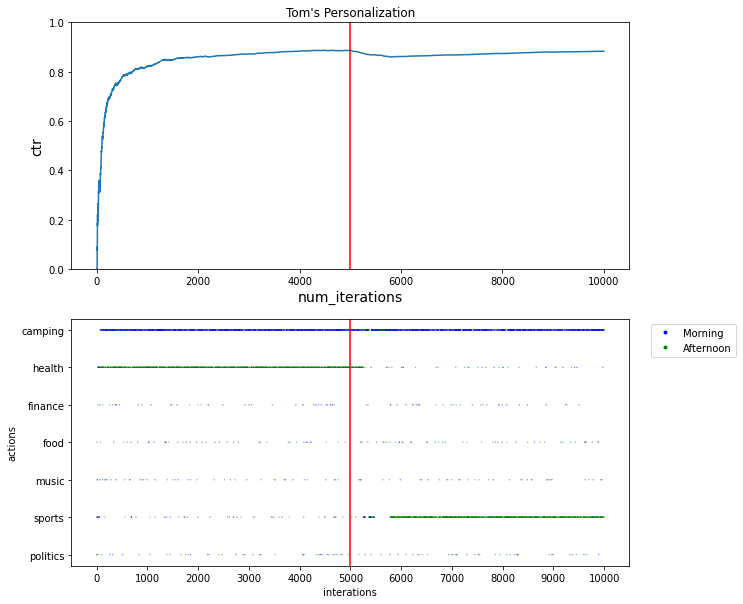

In [275]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")

num_iterations_per_cost_func = 5000
rewards_increment = -1e-05
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)

subplots_ctr_actions(ctr, record_info, actions, total_iterations)

* Given that the context switching is not very frequent (two contexts in this case), we can see the effects of favouring exploitation. 
* The average CTR value is higher than before (when the epsilon value was 0.2 in the previous sections) because the policy sticks to what it already knows best, therefore giving it a higher chance of gaining a reward.
* Where this policy lacks is in its ability to "explore". Its strong bias causes it to stick to a less optimal action. Its probably the same reason why it takes approximately 500 iterations after a context switch (red line) to readjust its bias through exploration. 
* Therefore the epsilon value is directly propotional to the number of context switches.
* To highlight this better, lets run the simulator with a much higher epsilon value.

#### 2. a. (i) Setting a high epsilon value such as 0.9, the policy will clearly favour exploration

Average CTR:  0.2264


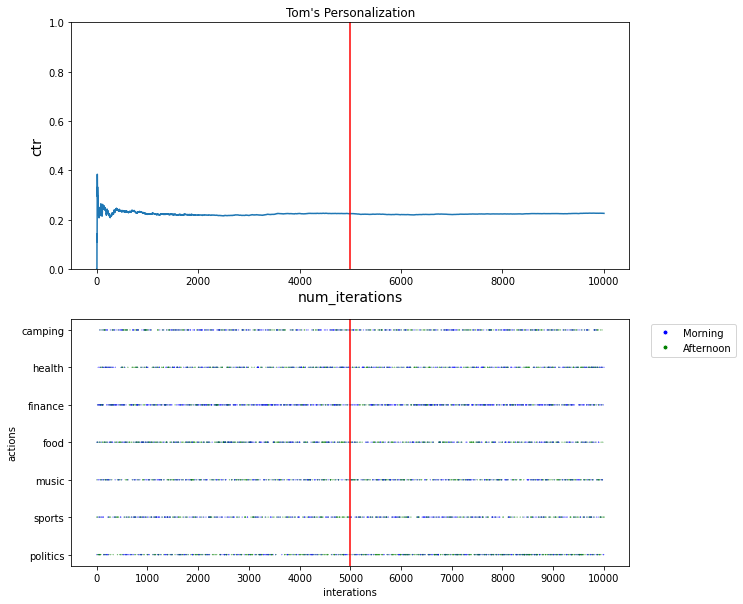

In [272]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.9")

num_iterations_per_cost_func = 5000
rewards_increment = -1e-05
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)

subplots_ctr_actions(ctr, record_info, actions, total_iterations)

* As expected, the performance with a higher epsilon value is comparatively worse. The policy has a higher tendency to explore and therefore is not "greedy" enough to maximize the rewards.
* It is also clearly evident in the actions vs. interations plot where the chosen actions are a lot more sparse. This indicates that the policy has little to no knowledge of the optimum action-values, given that its exploring most of the time.

### 2 b. Explore First
(Explain)

Average CTR:  0.5948


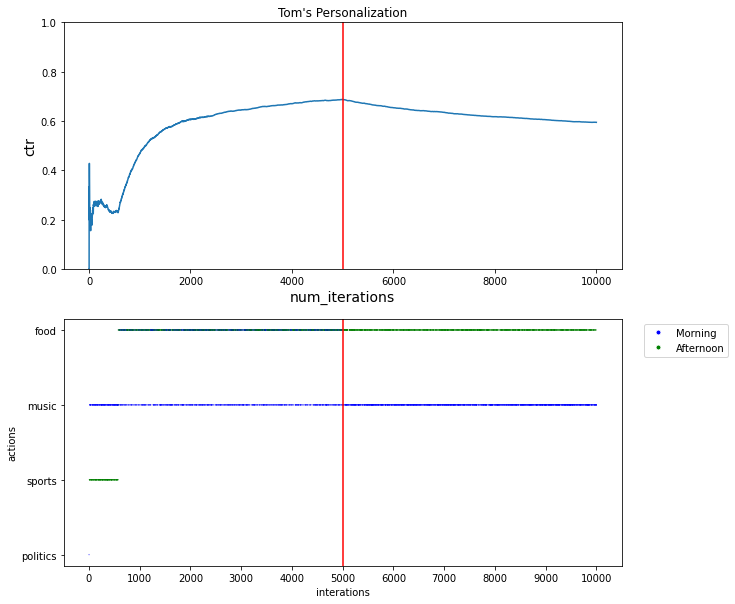

In [289]:
vw = pyvw.vw("--cb_explore_adf -q UA --first 2")

num_iterations_per_cost_func = 5000
rewards_increment = -1e-05
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)

subplots_ctr_actions(ctr, record_info, actions, total_iterations)

### 2 b. Softmax Explorer
(Explain)

Average CTR:  0.8944


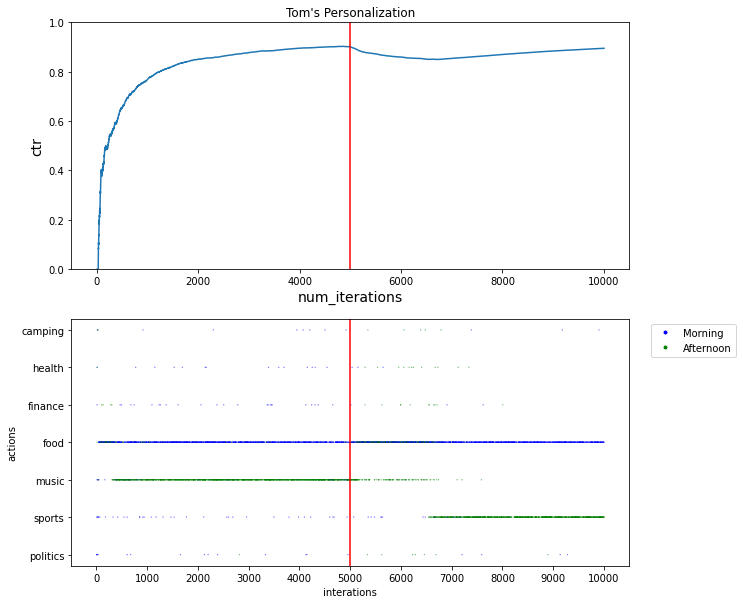

In [295]:
vw = pyvw.vw("--cb_explore_adf -q UA --softmax --lambda 7")

num_iterations_per_cost_func = 5000
rewards_increment = -1e-05
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)

subplots_ctr_actions(ctr, record_info, actions, total_iterations)